# CV Problem - Image Classification

In [1]:
from pickle import load # to load pickled files
import numpy as np # for data manipulation
import matplotlib.pyplot as plt # for displaying images

In [2]:
# function that loads pickled files and returns the data
def load_data(filename):
    return load(open(filename, 'rb'))

In [3]:
# variables
fn_train_image = "train_image.pkl"
fn_train_label = "train_label.pkl"
fn_test_image = "test_image.pkl"

## Load train images

In [4]:
# load training images
train_images = load_data(fn_train_image)

In [5]:
# find the length of train data
len(train_images)

8000

In [6]:
# create num_images variable
num_images = len(train_images)

In [7]:
# sneak-peak
len(train_images[0])

784

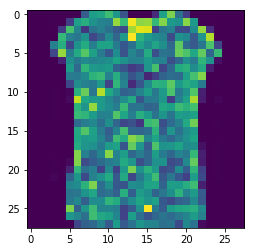

In [8]:
# display an image
plt.imshow(np.array(train_images[8]).reshape((28, 28)))

## Prepare train images

In [9]:
_X_train = []

In [10]:
# convert image array to numpy arrays and reshape them
for i in range(len(train_images)):
    curr_image = train_images[i]
    curr_image_np = np.array(curr_image).reshape(28, 28, 1)
    _X_train.append(curr_image_np)

In [11]:
X_train = np.array(_X_train)
X_train = X_train.astype('float32')
X_train = X_train / 255.0

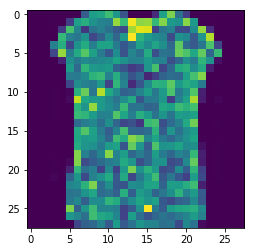

In [12]:
# sneak-peak to check if everything is ok
plt.imshow(X_train[8].reshape(28, 28))

## Load train labels

In [13]:
# load train labels
train_labels = load_data(fn_train_label)

In [14]:
# assert length
assert len(train_labels) == num_images

In [15]:
# find number of classes
max_class_id = max(train_labels)
max_class_id

6

Number of classes present are 7

In [16]:
num_classes = 7

## Prepare model creation

In [17]:
# we'll use keras for quick prototyping
from tensorflow.keras.utils import to_categorical

In [18]:
# create train labels
y_train = []

In [19]:
for i in range(num_images):
    y_train.append(to_categorical(train_labels[i], num_classes))

In [20]:
y_train = np.array(y_train)
y_train = y_train.astype('float32')
y_train = y_train / 255.0

In [21]:
# imports for shuffling train data since the current data is ordered according to class
from sklearn.utils import shuffle
_X_train_shuffled, _y_train_shuffled = shuffle(X_train, y_train)

In [22]:
# import for splitting data into train and validation
from sklearn.model_selection import train_test_split
X_train_shuffled, X_test, y_train_shuffled, y_test = train_test_split(_X_train_shuffled, _y_train_shuffled, test_size=0.1, random_state=42)

## Data Augmentation

In [23]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [24]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train_shuffled)

## Convolution Neural Network Model
We'll implement a Deep CNN Model with regularization techniques

In [25]:
# import keras model modules
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.models import Model

In [26]:
# define the model
x = Input(shape=(28, 28, 1))
conv1 = Conv2D(32, (3,3), padding='same', activation='relu')(x)
conv2 = Conv2D(32, (3,3), padding='same', activation='relu')(conv1)
conv2_maxpool = MaxPooling2D(pool_size=(2,2))(conv2)
conv2_maxpool_dropout = Dropout(0.25)(conv2_maxpool)

conv3 = Conv2D(64, (3,3), padding='same', activation='relu')(conv2_maxpool_dropout)
conv4 = Conv2D(64, (3,3), padding='same', activation='relu')(conv3)
conv4_maxpool = MaxPooling2D(pool_size=(2,2))(conv4)
conv4_maxpool_dropout = Dropout(0.25)(conv4_maxpool)

flatten = Flatten()(conv4_maxpool_dropout)
fc1 = Dense(512, activation='relu')(flatten)
fc1_dropout = Dropout(0.5)(fc1)
fc3 = Dense(num_classes, activation='softmax')(fc1_dropout)

model = Model(inputs=x, outputs=fc3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
__________

## Compile Model
Compile the model with
1. loss function as categorical crossentropy
2. optimizer as Adam
3. metric as accuracy

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Model Hyper-parameters

In [28]:
n_epochs = 200
batch_size = 512

Finally, it's time to train our model

In [29]:
# model.fit(X_train_shuffled, y_train_shuffled, epochs=n_epochs, verbose=1, batch_size=batch_size, shuffle=True, validation_data=(X_test, y_test))

In [30]:
model.fit_generator(datagen.flow(X_train_shuffled, y_train_shuffled, batch_size=batch_size), epochs=n_epochs, verbose=1, steps_per_epoch=X_train_shuffled.shape[0]//batch_size, validation_data=(X_test, y_test))

Epoch 1/200
14/14 [==============================] - 4s 276ms/step - loss: 0.0052 - acc: 0.4396 - val_loss: 0.0034 - val_acc: 0.6213
Epoch 2/200
14/14 [==============================] - 1s 64ms/step - loss: 0.0035 - acc: 0.6267 - val_loss: 0.0032 - val_acc: 0.6562
Epoch 3/200
14/14 [==============================] - 1s 59ms/step - loss: 0.0032 - acc: 0.6466 - val_loss: 0.0031 - val_acc: 0.6563
Epoch 4/200
14/14 [==============================] - 1s 59ms/step - loss: 0.0030 - acc: 0.6660 - val_loss: 0.0028 - val_acc: 0.6937
Epoch 5/200
14/14 [==============================] - 1s 59ms/step - loss: 0.0030 - acc: 0.6764 - val_loss: 0.0027 - val_acc: 0.7037
Epoch 6/200
14/14 [==============================] - 1s 58ms/step - loss: 0.0028 - acc: 0.7086 - val_loss: 0.0027 - val_acc: 0.7000
Epoch 7/200
14/14 [==============================] - 1s 58ms/step - loss: 0.0028 - acc: 0.7043 - val_loss: 0.0026 - val_acc: 0.7463
Epoch 8/200
14/14 [==============================] - 1s 58ms/step - loss: 0

14/14 [==============================] - 1s 59ms/step - loss: 0.0015 - acc: 0.8556 - val_loss: 0.0012 - val_acc: 0.8887
Epoch 63/200
14/14 [==============================] - 1s 58ms/step - loss: 0.0014 - acc: 0.8594 - val_loss: 0.0013 - val_acc: 0.8700
Epoch 64/200
14/14 [==============================] - 1s 59ms/step - loss: 0.0014 - acc: 0.8533 - val_loss: 0.0012 - val_acc: 0.8775
Epoch 65/200
14/14 [==============================] - 1s 60ms/step - loss: 0.0015 - acc: 0.8536 - val_loss: 0.0012 - val_acc: 0.8775
Epoch 66/200
14/14 [==============================] - 1s 60ms/step - loss: 0.0014 - acc: 0.8572 - val_loss: 0.0013 - val_acc: 0.8700
Epoch 67/200
14/14 [==============================] - 1s 59ms/step - loss: 0.0015 - acc: 0.8553 - val_loss: 0.0012 - val_acc: 0.8813
Epoch 68/200
14/14 [==============================] - 1s 59ms/step - loss: 0.0015 - acc: 0.8496 - val_loss: 0.0013 - val_acc: 0.8712
Epoch 69/200
14/14 [==============================] - 1s 60ms/step - loss: 0.0015 

14/14 [==============================] - 1s 59ms/step - loss: 0.0011 - acc: 0.8891 - val_loss: 0.0012 - val_acc: 0.8912
Epoch 124/200
14/14 [==============================] - 1s 60ms/step - loss: 0.0011 - acc: 0.8907 - val_loss: 0.0012 - val_acc: 0.8800
Epoch 125/200
14/14 [==============================] - 1s 59ms/step - loss: 0.0012 - acc: 0.8843 - val_loss: 0.0013 - val_acc: 0.8738
Epoch 126/200
14/14 [==============================] - 1s 58ms/step - loss: 0.0012 - acc: 0.8824 - val_loss: 0.0011 - val_acc: 0.9013
Epoch 127/200
14/14 [==============================] - 1s 60ms/step - loss: 0.0012 - acc: 0.8780 - val_loss: 0.0012 - val_acc: 0.8850
Epoch 128/200
14/14 [==============================] - 1s 59ms/step - loss: 0.0012 - acc: 0.8746 - val_loss: 0.0012 - val_acc: 0.8987
Epoch 129/200
14/14 [==============================] - 1s 59ms/step - loss: 0.0012 - acc: 0.8725 - val_loss: 0.0012 - val_acc: 0.8813
Epoch 130/200
14/14 [==============================] - 1s 60ms/step - loss: 

14/14 [==============================] - 1s 59ms/step - loss: 9.5426e-04 - acc: 0.9076 - val_loss: 0.0011 - val_acc: 0.9050
Epoch 185/200
14/14 [==============================] - 1s 59ms/step - loss: 9.6990e-04 - acc: 0.9060 - val_loss: 0.0012 - val_acc: 0.8987
Epoch 186/200
14/14 [==============================] - 1s 58ms/step - loss: 9.3027e-04 - acc: 0.9120 - val_loss: 0.0011 - val_acc: 0.8988
Epoch 187/200
14/14 [==============================] - 1s 58ms/step - loss: 9.2159e-04 - acc: 0.9032 - val_loss: 0.0013 - val_acc: 0.8900
Epoch 188/200
14/14 [==============================] - 1s 60ms/step - loss: 8.9437e-04 - acc: 0.9086 - val_loss: 0.0013 - val_acc: 0.8750
Epoch 189/200
14/14 [==============================] - 1s 60ms/step - loss: 9.5842e-04 - acc: 0.9074 - val_loss: 0.0011 - val_acc: 0.9062
Epoch 190/200
14/14 [==============================] - 1s 60ms/step - loss: 9.1244e-04 - acc: 0.9123 - val_loss: 0.0012 - val_acc: 0.9025
Epoch 191/200
14/14 [===========================